#  Kredi Kartı Müşterileri (Churn Analizi)

## Takım Üyeleri
- Bekir Elibol
- Samet Saydam
- Onur Altun

# İçindekiler

1. Giriş  
   • Amaç  
   • Veri Seti Bilgisi  

2. Keşifsel Veri Analizi  

3. Model Kurulumu  
   • Aykırı Değerlerin Hariç Tutulduğu Durum  
   • Aykırı Değerlerin Hariç Tutulmadığı Durum  

4. Sonuçların Değerlendirilmesi


# 1. Giriş

## Amaç  
Bu projede, **Kredi Kartı Müşterileri** veri setini analiz ederek müşterilerin hizmetten ayrılıp ayrılmayacağını (churn) tahmin etmeyi amaçlıyoruz. Makine öğrenmesi, özellikle müşteri kaybını önceden tahmin etmek ve bu kaybı azaltmak için alınacak aksiyonları belirlemede oldukça kritik bir rol oynamaktadır.  

Amacımız, bankanın kredi kartı hizmetini kullanmayı bırakma olasılığı yüksek olan müşterileri doğru bir şekilde tespit etmektir. Müşteri kaybı; kredi limiti, işlem sıklığı, müşteri ilişkileri ve kullanım alışkanlıkları gibi birçok faktörden etkilenebilir. Bu proje kapsamında bu faktörleri veri setindeki değişkenler aracılığıyla analiz edecek ve hangi özelliklerin ayrılma olasılığı üzerinde en çok etkili olduğunu belirleyeceğiz.

Projede **Lojistik Regresyon**, **K-En Yakın Komşu (KNN)**, **Destek Vektör Makineleri (SVM)** ve **Rastgele Orman (Random Forest)** gibi çeşitli makine öğrenmesi algoritmalarını kullanacağız. 

Modellerimizin başarımını **karmaşıklık matrisi (confusion matrix)**, **sınıflandırma raporu (classification report)** ve **çapraz doğrulama (cross-validation)** gibi yöntemlerle değerlendireceğiz. Projenin sonunda tüm modellerin performanslarını karşılaştırarak en iyi sonucu veren modeli belirleyeyip bu modeldeki en önemli özellikleri bulacağız.

---

## Veri Seti Bilgisi

Bu veri seti, bir bankanın kredi kartı müşterilerine ait demografik, finansal ve davranışsal bilgileri içermektedir. Hedef değişken `Attrition_Flag` olup, bir müşterinin hizmetten ayrılıp ayrılmadığını gösterir:

- **Attrited Customer**: Hizmetten ayrılan müşteri (1)  
- **Existing Customer**: Halen aktif müşteri (0)

Veri setinde yer alan 23 sütunun açıklamaları aşağıdaki gibidir:

1.  **CLIENTNUM** – Müşteri numarası *(analiz dışı tutulur)* 
2. **Attrition_Flag** – Hedef değişken: Müşteri hizmeti bırakmış mı? (1: Evet, 0: Hayır)  
3. **Customer_Age** – Müşterinin yaşı  
4. **Gender** – Cinsiyet (M / F)  
5. **Dependent_count** – Müşterinin bakmakla yükümlü olduğu kişi sayısı  
6. **Education_Level** – Eğitim seviyesi  
7. **Marital_Status** – Medeni hali  
8. **Income_Category** – Gelir aralığı  
9. **Card_Category** – Kredi kartı tipi  
10. **Months_on_book** – Müşterinin kaç aydır bankada olduğu  
11. **Total_Relationship_Count** – Bankayla olan toplam ilişki sayısı (ürün sayısı)  
12. **Months_Inactive_12_mon** – Son 12 ayda kaç ay pasif kaldığı  
13. **Contacts_Count_12_mon** – Son 12 ayda bankayla kaç kez iletişime geçtiği  
14. **Credit_Limit** – Müşteriye tanınan toplam kredi limiti  
15. **Total_Revolving_Bal** – Toplam dönen bakiye (borç)  
16. **Avg_Open_To_Buy** – Ortalama kullanılabilir kredi miktarı  
17. **Total_Amt_Chng_Q4_Q1** – 1. ve 4. çeyrek arasındaki harcama tutarı değişimi  
18. **Total_Trans_Amt** – Toplam işlem tutarı (12 aylık)  
19. **Total_Trans_Ct** – Toplam işlem sayısı (12 aylık)  
20. **Total_Ct_Chng_Q4_Q1** – 1. ve 4. çeyrek arasındaki işlem sayısı değişimi  
21. **Avg_Utilization_Ratio** – Ortalama kredi kullanım oranı  

> **Not:** `CLIENTNUM` sütunu ve son 2 sütun doğrudan analiz için anlamlı bilgi taşımadığından modelleme sürecinde kullanılmayacaktır.


# 2. Keşifsel Veri Analizi

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import ListedColormap
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("BankChurners.csv")
df = data.iloc[:,1:-2]
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [3]:
df.shape

(10127, 20)

In [4]:
df.isnull().sum()

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

> Veri setinde eksik veri bulunmadığı görüldü.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [6]:
df.nunique(axis=0)

Attrition_Flag                 2
Customer_Age                  45
Gender                         2
Dependent_count                6
Education_Level                7
Marital_Status                 4
Income_Category                6
Card_Category                  4
Months_on_book                44
Total_Relationship_Count       6
Months_Inactive_12_mon         7
Contacts_Count_12_mon          7
Credit_Limit                6205
Total_Revolving_Bal         1974
Avg_Open_To_Buy             6813
Total_Amt_Chng_Q4_Q1        1158
Total_Trans_Amt             5033
Total_Trans_Ct               126
Total_Ct_Chng_Q4_Q1          830
Avg_Utilization_Ratio        964
dtype: int64

> Kategorik verilerin farklı değerlerinin fazla olmaması One Hot Encoding işlemi için uygun gözükmetedir.

In [7]:
num_cols = list(df.select_dtypes(["int64","float64"]))
cat_cols = list(df.select_dtypes("object"))

> Kategorik ve numerik alanlar veri görselleştirme ve düzenleme amaçlı ayrı ayrı tespit edilmiştir.

In [8]:
for col in cat_cols:
    print(f"--- {col} ---")
    print(df[col].value_counts(dropna=False))
    print("\n")

--- Attrition_Flag ---
Attrition_Flag
Existing Customer    8500
Attrited Customer    1627
Name: count, dtype: int64


--- Gender ---
Gender
F    5358
M    4769
Name: count, dtype: int64


--- Education_Level ---
Education_Level
Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: count, dtype: int64


--- Marital_Status ---
Marital_Status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: count, dtype: int64


--- Income_Category ---
Income_Category
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: count, dtype: int64


--- Card_Category ---
Card_Category
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: count, dtype: int64




> Her bir kategorik değişkendeki sayısal dağılım verilmiştir. Hedef değişikenimiz 'Attrition_Flag' alanının dengeli olmadığı görülmüştür.

In [9]:
df.describe()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


### Numerik Değişkenlerin Görselleştirilmesi

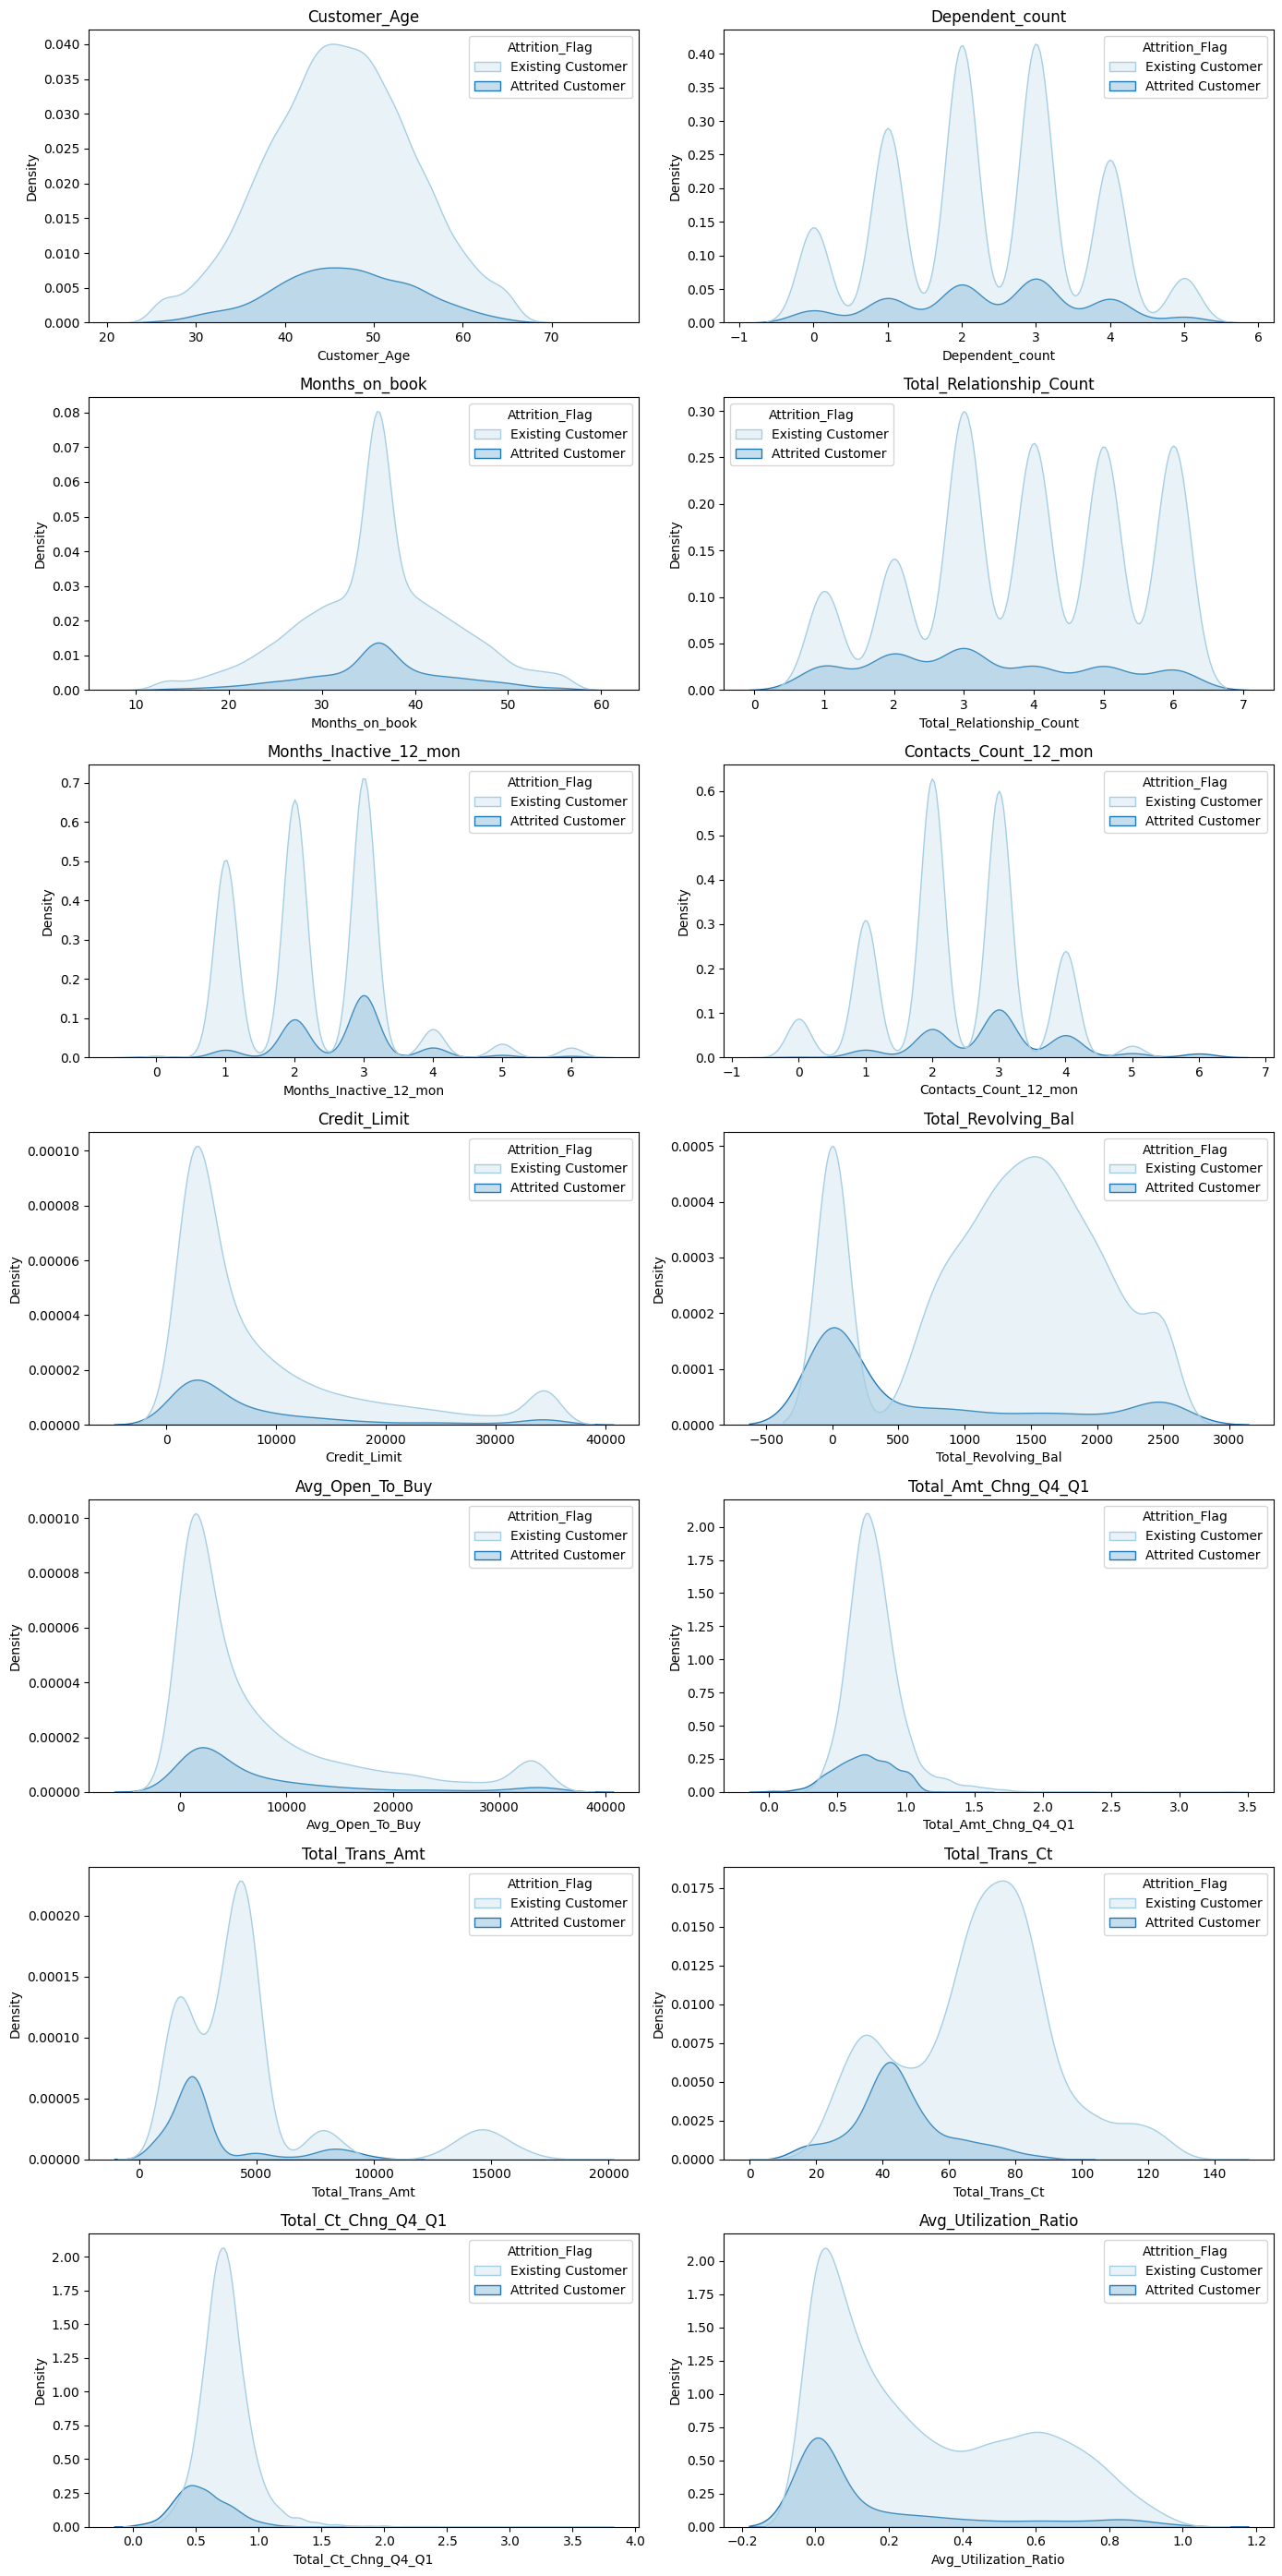

In [10]:
palette = sns.color_palette("Paired")
n_cols = 2
n_rows = 7
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))

for i, col in enumerate(num_cols):
    ax = axes[i // n_cols, i % n_cols]
    sns.kdeplot(
        data=df, 
        x=col, 
        hue='Attrition_Flag', 
        fill=True, 
        ax=ax, 
        palette=palette
    )
    ax.set_title(col)
    plt.tight_layout()

plt.show()

> Ayrılmış ve mevcut müşteriler için  en fazla davaranış farklılığı gösteren alanlar 'Total_Relationship_Count', 'Total_Revolving_Bal', 'Total_Trans_Ct' ve 'Avg_Utilization_Ratio' olarak gözükmektedir.   

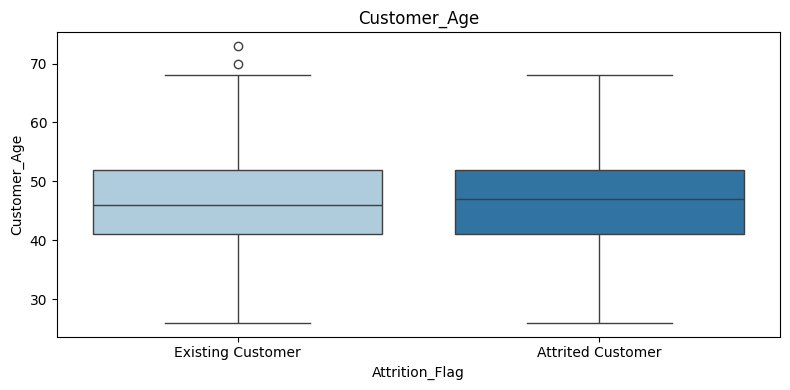

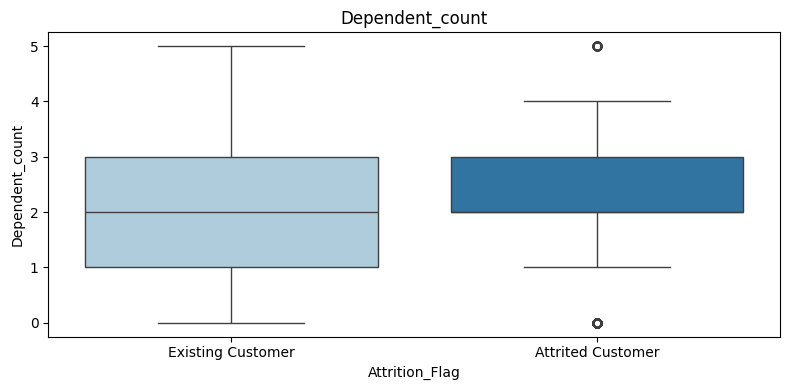

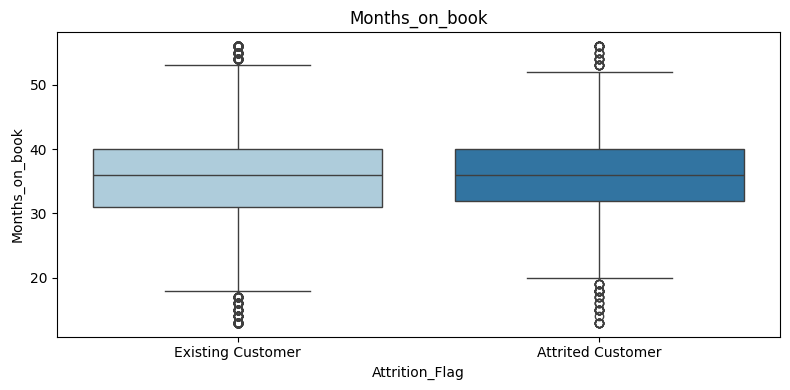

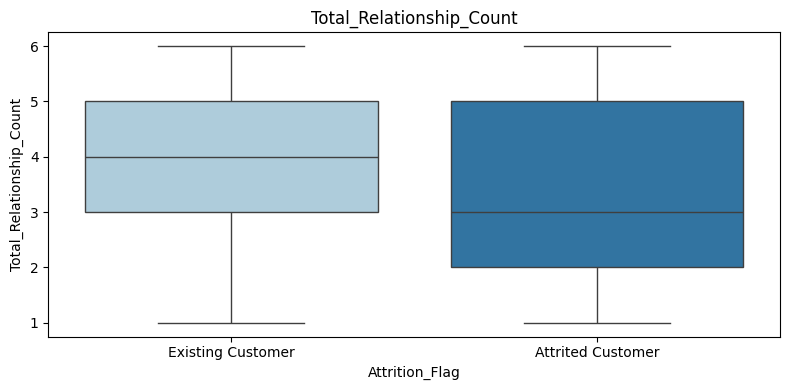

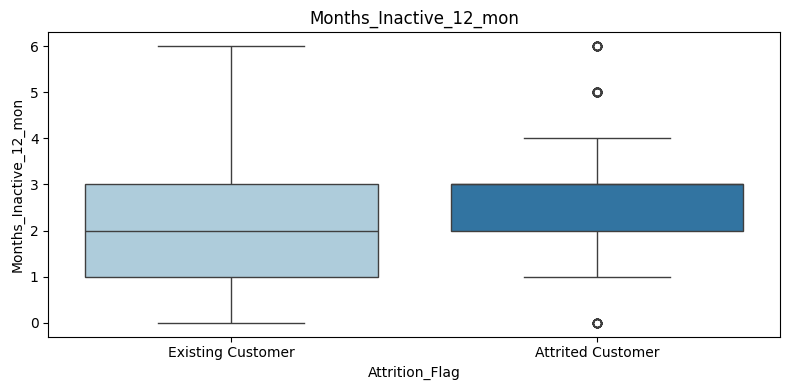

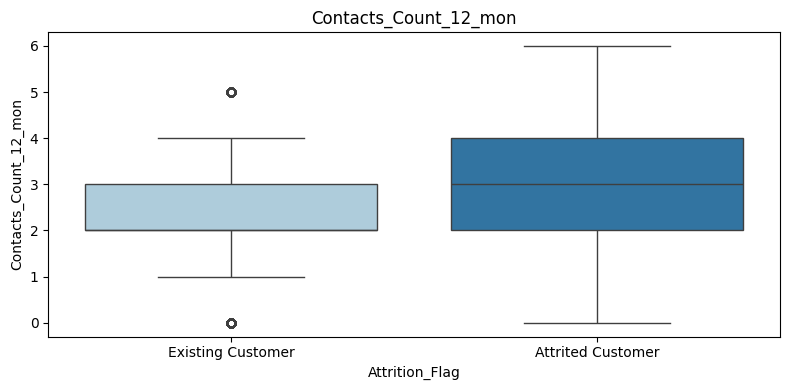

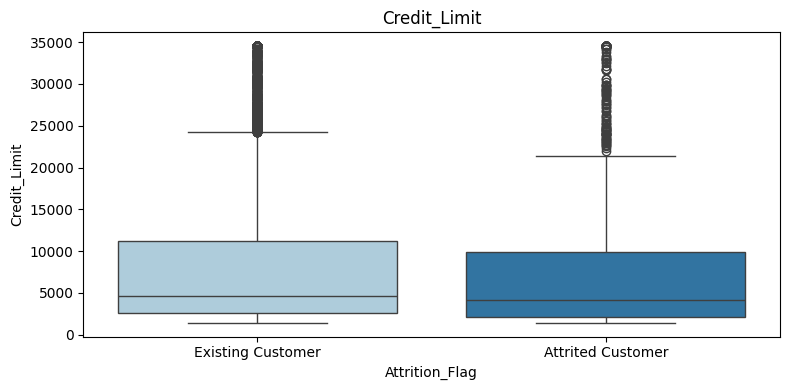

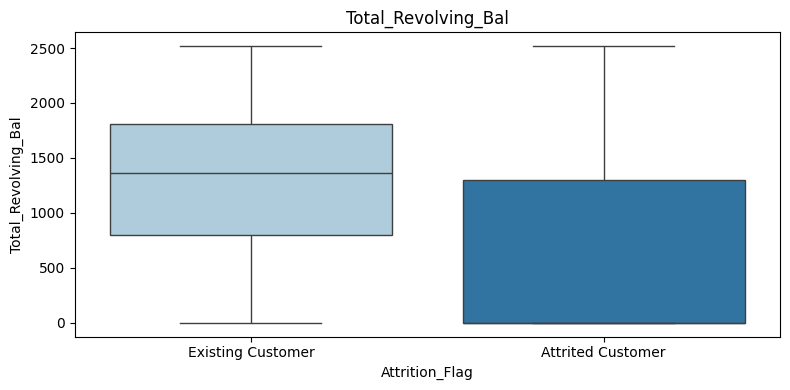

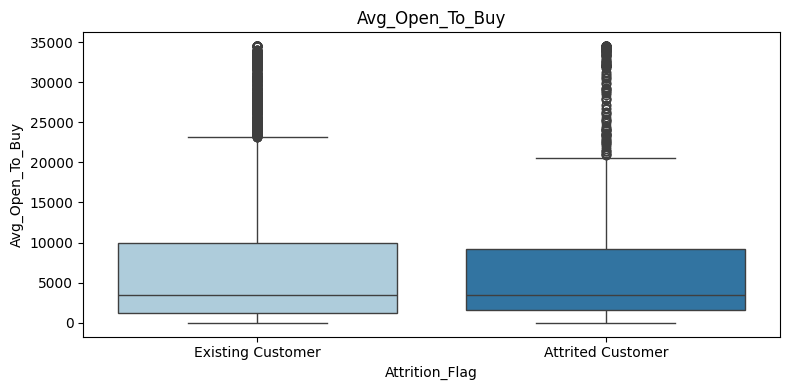

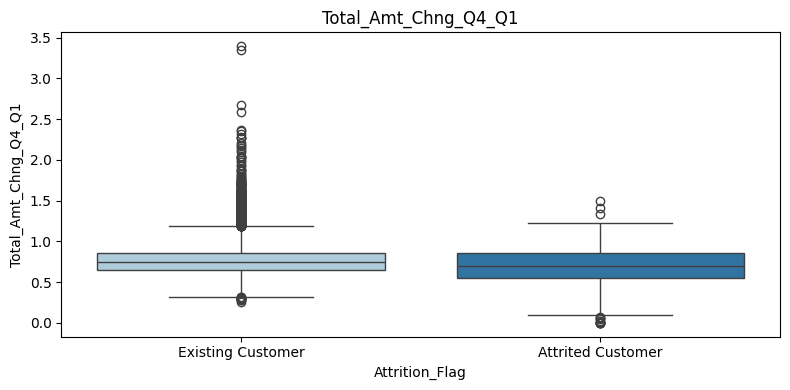

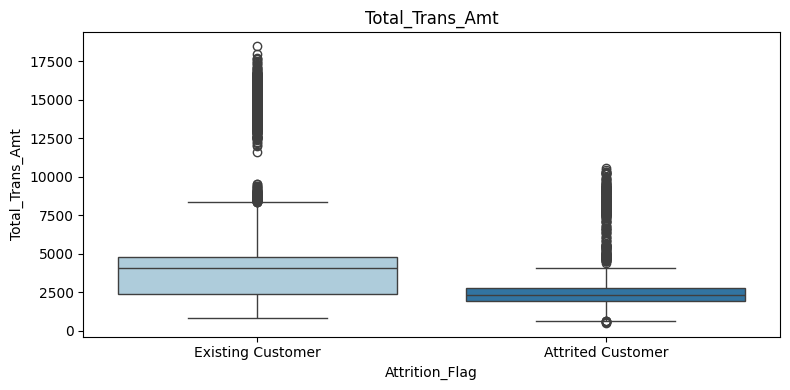

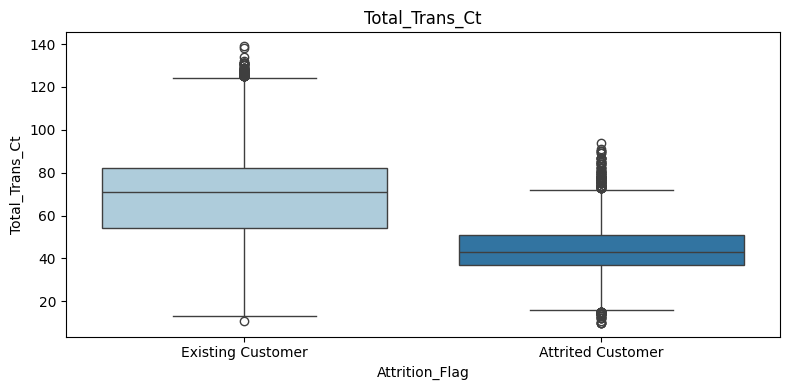

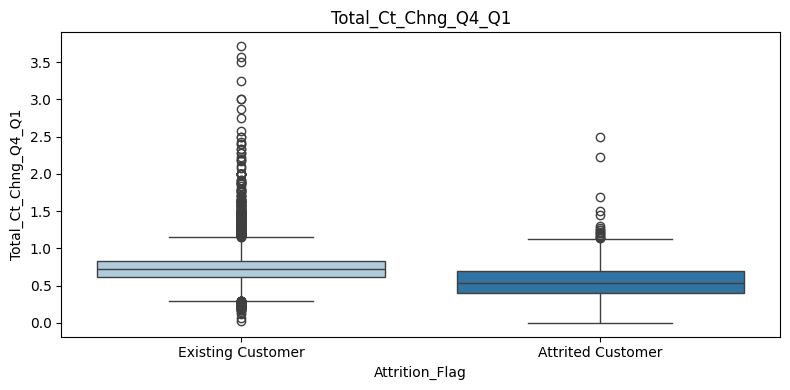

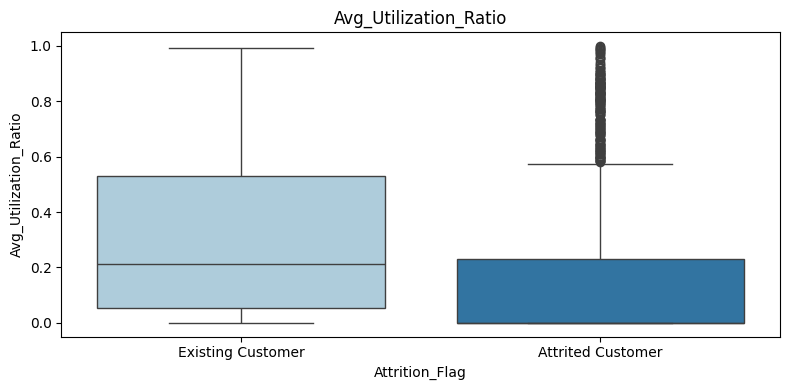

In [11]:
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='Attrition_Flag', y=col, data=df, palette=palette)
    plt.title(f'{col}')
    plt.tight_layout()
    plt.show()

> Boxplot'a göre çok fazla sayıda aykırı değer göze çarpmaktadır. Fakat finansal verilerde VIP müşteri kavramı olabilir. Bu yüzden bunları veri setinden çıkarmak bilgi kaybı riski açısından sakıncalıdır. Aşğıda aykırı değer analizi farklı bir yöntemle ayrıca yapılacakltır.

### Kategorik Değişkenlerin Görselleştirilmesi

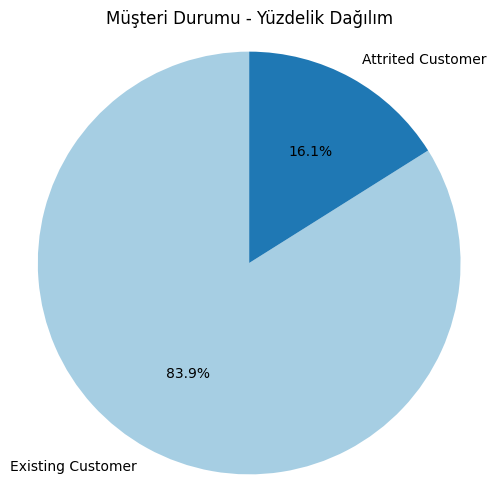

In [12]:
labels = df['Attrition_Flag'].value_counts().index
sizes = df['Attrition_Flag'].value_counts(normalize=True) * 100

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=palette[:len(sizes)])
plt.title("Müşteri Durumu - Yüzdelik Dağılım")
plt.axis('equal')
plt.show()

> Hedef değişkenimiz dengeli olmadığı bir kez daha görülmektedir.

Hata (Attrition_Flag): index must be a MultiIndex to unstack, <class 'pandas.core.indexes.base.Index'> was passed


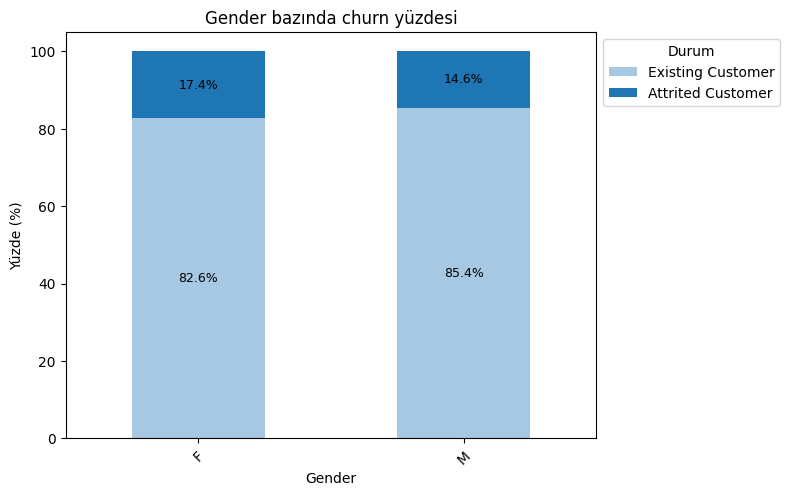

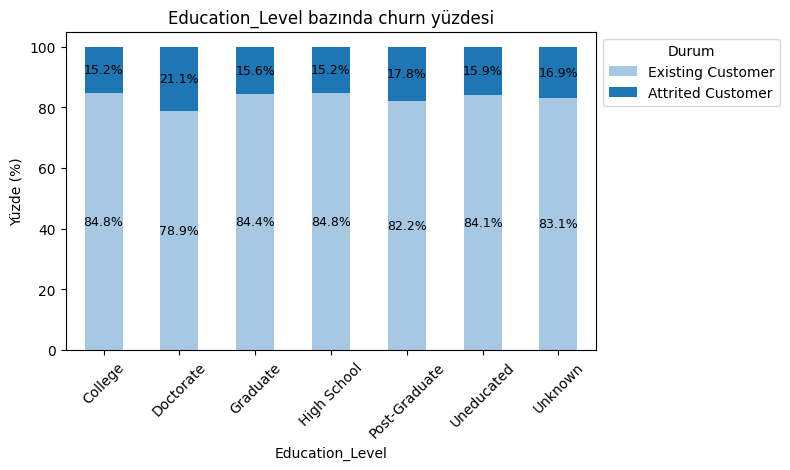

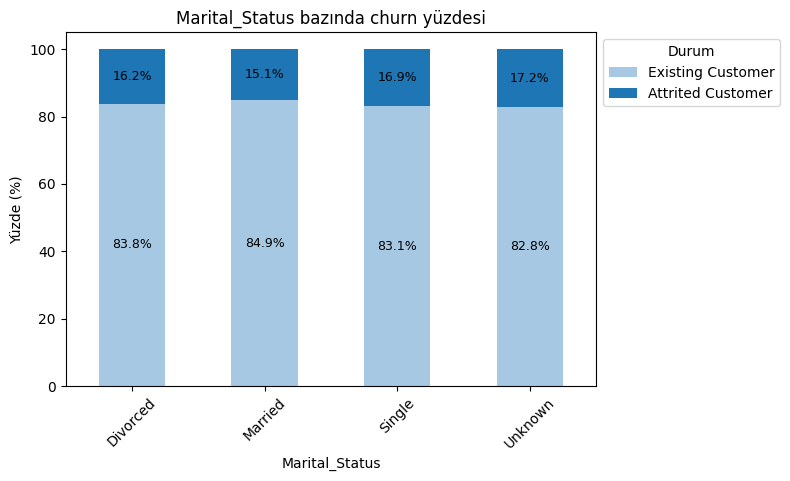

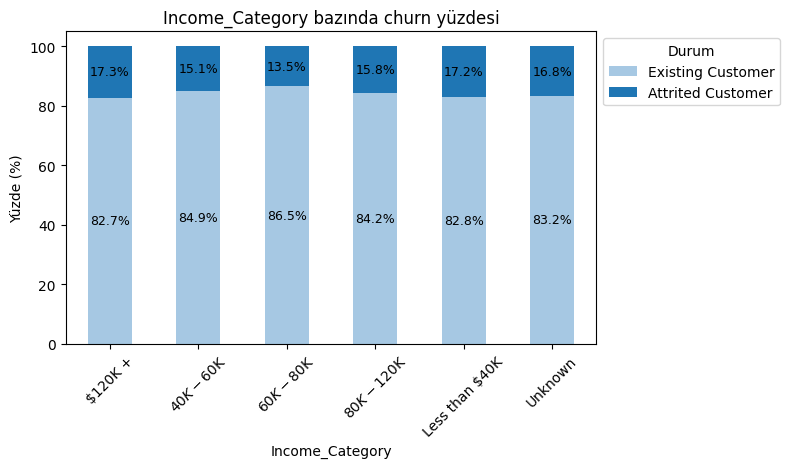

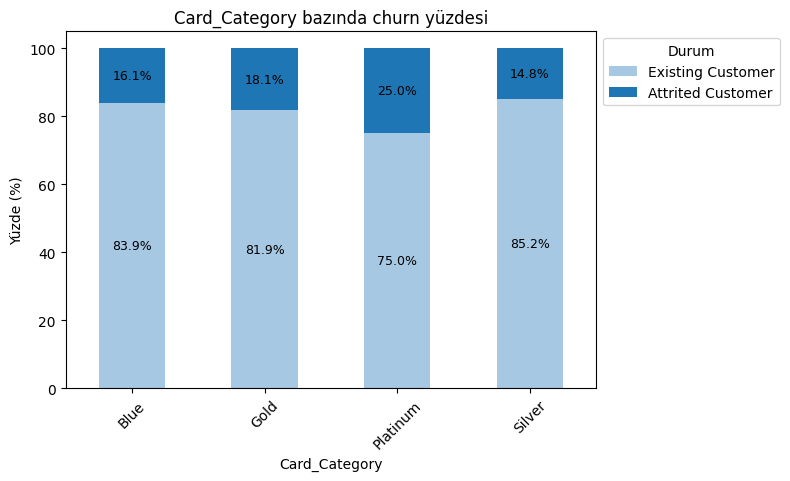

In [13]:
custom_cmap = ListedColormap(['#a6c8e3', '#1f76b4'])

for col in cat_cols:
    try:
        churn_ratio = (
            df.groupby(col)['Attrition_Flag']
            .value_counts(normalize=True)
            .unstack()
            .fillna(0) * 100
        )
        churn_ratio = churn_ratio[churn_ratio.columns[::-1]]

        ax = churn_ratio.plot(
            kind='bar',
            stacked=True,
            figsize=(8, 5),
            colormap=custom_cmap
        )

        for container in ax.containers:
            labels = [f'{v.get_height():.1f}%' if v.get_height() > 0 else '' for v in container]
            ax.bar_label(container, labels=labels, label_type='center', fontsize=9)

        plt.ylabel("Yüzde (%)")
        plt.title(f"{col} bazında churn yüzdesi")
        plt.legend(title='Durum', bbox_to_anchor=(1.0, 1))
        plt.tight_layout()
        plt.xticks(rotation=45)
        plt.show()

    except Exception as e:
        print(f"Hata ({col}): {e}")

> Kategorik verilerin hedef değişkenin tayini açısından kritik seviyede bir etki göstermediği görülmektedir.

In [14]:
df['Attrition_Flag'] = df['Attrition_Flag'].map({
    'Existing Customer': 0,
    'Attrited Customer': 1
})
df['Gender'] = df['Gender'].map({'F': 0, 'M': 1})

> Hedef değişken ve cinsiyet bilgileri ikişer farklı değerden oluştukları için ilgili değişkenlere manuel olarak 1 ve 0 değerleri atanmıştır.

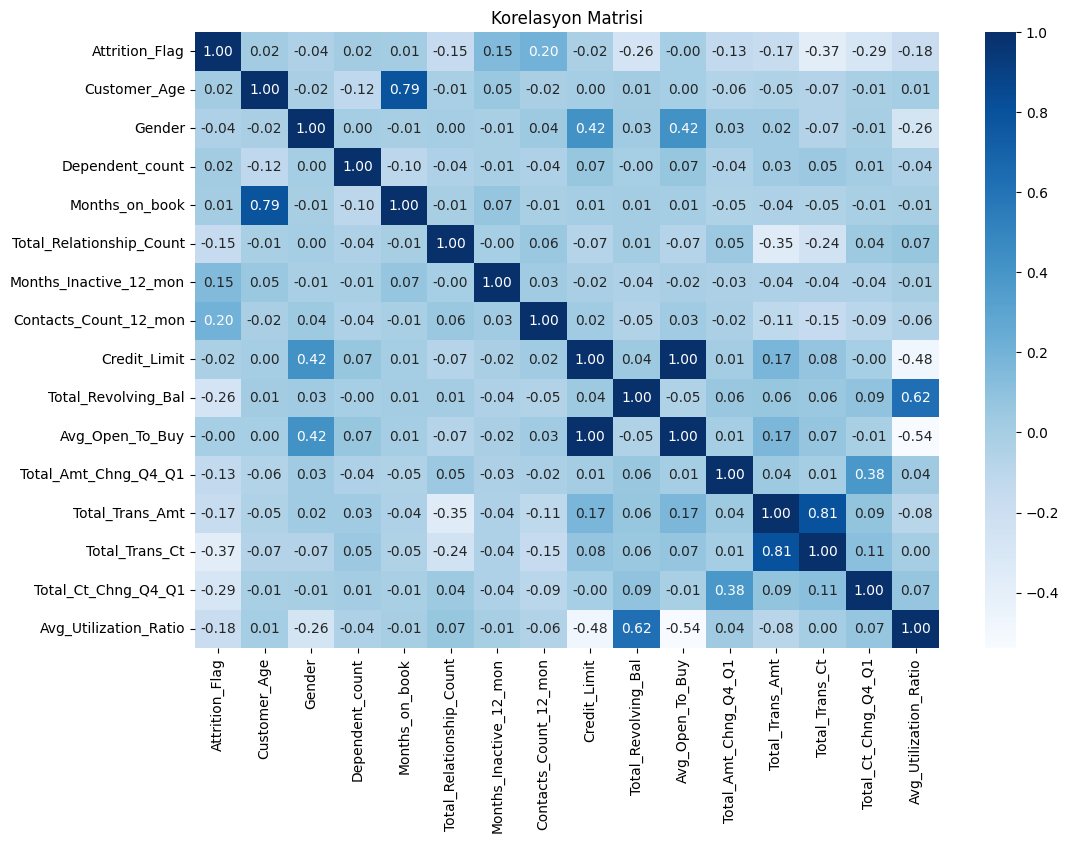

In [15]:
plt.figure(figsize=(12, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='Blues', fmt=".2f")
plt.title("Korelasyon Matrisi")
plt.show()

>  Hedef değişkenle korelasyonu en yüksek değişkenler 'Total_Ct_Chng_Q4_Q1', 'Total_Trans_Ct' ve 'Contacts_Count_12_mon' olarak gözükmektedir. Hedef değişkenle yüksek korelasyona sahip özelliğin bulunmaması, modelin genelleme yeteneği ve doğruluğu açısından genellikle daha sağlıklı bir durumdur.

In [16]:
def outlierDetection(df, col): #Z-skoru ile aykırı değer indisi bulma
    upper = df[col].mean() + 3*df[col].std()
    lower = df[col].mean() - 3*df[col].std()
    indices = df[((df[col] > upper)|(df[col] < lower))].index.to_list()
    return  indices 

In [17]:
outlier_counts = {}
all_outlier_indices = []

for col in num_cols:
    inds = outlierDetection(df, col)
    outlier_counts[col] = len(inds)
    all_outlier_indices.extend(inds)

all_outlier_indices = list(np.unique(all_outlier_indices))

print("Kolon bazında aykırı değer sayıları:")
for col, count in outlier_counts.items():
    print(f"{col}: {count}")

print(f"\nToplam benzersiz aykırı değer sayısı: {len(all_outlier_indices)}")

Kolon bazında aykırı değer sayıları:
Customer_Age: 1
Dependent_count: 0
Months_on_book: 0
Total_Relationship_Count: 0
Months_Inactive_12_mon: 124
Contacts_Count_12_mon: 54
Credit_Limit: 0
Total_Revolving_Bal: 0
Avg_Open_To_Buy: 0
Total_Amt_Chng_Q4_Q1: 163
Total_Trans_Amt: 391
Total_Trans_Ct: 2
Total_Ct_Chng_Q4_Q1: 113
Avg_Utilization_Ratio: 0

Toplam benzersiz aykırı değer sayısı: 814


> Toplam 814 farklı kayıtta aykırı değer tespit edilmiştir. Bunları direkt veri setinden çıkarmak seçeneklerimizden birisi ama finansal veri setlerinde tehlikeli olduğu için aykırı değerler tutulabilir de. Biz her iki halini de dörder makine öğrenmesi modeli ile değerlendireceğiz.

# 3. Model Kurulumu

In [18]:
df_dropped=df.copy()
df_dropped.drop(index=all_outlier_indices, inplace = True)
df_dropped.shape 

(9313, 20)

> Tutulan indis bilgileri ile aykırı değerler veri setinden çıkartılmıştır.
>  Aşağıda ise:
>- One Hot Encoding
>- Ölçeklendirme
>- Veriyi eğitim ve test olarak ayırma
>- Hedef değişkenin dengesiz dağılımından ötürü de 'stratify' filtresi ve SMOTE işlemi
> adımları uygulannmıştır.

In [19]:
df_dropped = pd.get_dummies(df_dropped, columns=['Education_Level', 'Marital_Status', 'Card_Category', 'Income_Category'], drop_first=False).astype(int)
df_dropped = df_dropped.drop(columns=['Education_Level_Unknown', 'Marital_Status_Unknown', 'Income_Category_Unknown','Card_Category_Platinum'])
df_dropped.shape

(9313, 33)

In [20]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_dropped)

df_dropped = pd.DataFrame(scaled, columns=df_dropped.columns)

X = df_dropped.iloc[:, 1:]
X.head()

,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Marital_Status_Married,Marital_Status_Single,Card_Category_Blue,Card_Category_Gold,Card_Category_Silver,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K
0,0.409091,1.0,0.4,0.534884,0.4,0.2,0.4,0.077756,0.495431,0.079970,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.363636,1.0,1.0,0.418605,0.8,0.6,0.4,0.160530,0.582837,0.152928,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.704545,0.0,0.4,0.813953,0.8,0.4,0.4,0.030171,0.270163,0.050792,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.431818,0.0,0.4,0.558140,1.0,0.2,0.4,0.393978,0.459674,0.385652,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.477273,1.0,0.2,0.674419,0.8,0.4,0.0,0.590755,0.715137,0.555617,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [21]:
y = df_dropped.iloc[:, 0]
y

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
9308    1.0
9309    1.0
9310    1.0
9311    1.0
9312    1.0
Name: Attrition_Flag, Length: 9313, dtype: float64

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True, stratify=y)

In [23]:
sm = SMOTE(random_state = 69, sampling_strategy = 1.0)

X_train, y_train = sm.fit_resample(X_train, y_train)

In [24]:
df_notdropped=df.copy()
df_notdropped.shape

(10127, 20)

> Yukarıda izlenen adımlar, aykırı değerlerin veri setinden çıkarılmadığı versiyonda da aşağıda uygulanmıştır.

In [25]:
df_notdropped = pd.get_dummies(df_notdropped, columns=['Education_Level', 'Marital_Status', 'Card_Category', 'Income_Category'], drop_first=False).astype(int)
df_notdropped = df_notdropped.drop(columns=['Education_Level_Unknown', 'Marital_Status_Unknown', 'Income_Category_Unknown','Card_Category_Platinum'])
df_notdropped.shape

(10127, 33)

In [26]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_notdropped)

df_notdropped = pd.DataFrame(scaled, columns=df_notdropped.columns)

X2 = df_notdropped.iloc[:, 1:]
X2.shape

(10127, 32)

In [27]:
y2 = df_notdropped.iloc[:, 0]
y2

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
10122    0.0
10123    1.0
10124    1.0
10125    1.0
10126    1.0
Name: Attrition_Flag, Length: 10127, dtype: float64

In [28]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=104, test_size=0.25, shuffle=True, stratify=y2)

In [29]:
sm = SMOTE(random_state = 69, sampling_strategy = 1.0)

X_train2, y_train2 = sm.fit_resample(X_train2, y_train2)

> Aşağıda modeller ve cross-validation için fonksiyon tanımlanmıştır. Böylece 2 farklı versiyon için 4 makine öğrenmesi metodu (toplamda 8 model) için aynı kodlar tekrar tekrar yazılmayacaktır.

In [30]:
def Models(model, X_train, X_test, y_train, y_test):
    if model == 'LR':
        model = LogisticRegression()
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        print(confusion_matrix(y_test, pred))
        print(classification_report(y_test, pred))
    elif model == 'SVC':
        model = SVC()
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        print(confusion_matrix(y_test, pred))
        print(classification_report(y_test, pred))
    elif model == 'KNN':
        model = KNeighborsClassifier()
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        print(confusion_matrix(y_test, pred))
        print(classification_report(y_test, pred))
    elif model == 'RF':
        model = RandomForestClassifier()
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        print(confusion_matrix(y_test, pred))
        print(classification_report(y_test, pred))
    else:
        print("Desteklenmeyen model ismi.")
        return

In [31]:
def Cross(model, X, y):
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    cv_score = cross_val_score(model, X, y, cv=cv)
    cv_score_mean = format(100*cv_score.mean(), '.2f')
    return float(cv_score_mean)

> Aşağıda aykırı değerlerin veri setinden çıkarıldığı ve çıkarılmadığı 2 farklı versiyon için de:
> - Varsayılan parametreler ile 4 farklı modelin çalıştırılması
> - GridSearchCV ile hiperparametre optimizasyonu yapılarak en iyi model parametrelerinin bulunması
> - Bu parametrelerle modelin tekrar çalıştırılması
> - Karmaşıklık matrisi (DP, DN, YP, YN sayıları) ile sınıflandırma raporu (accuracy ve f-1 score) sonuçlarının verilmesi
> - 'ROC curve' grafiği, eğitim ve test verilerinin 'AUC' skoru farkının gözlemlenmesi ile aşırı öğrenme analizinin yapılması
> - Çapraz doğrulama ile ortalama 'accuracy' değerlerinin hesaplanması adımları izlenecektir.

## Aykırı Değerlerin Hariç Tutulduğu Durum

### Lojistik Regresyon

In [32]:
Models('LR', X_train, X_test, y_train, y_test)

[[1680  265]
 [  72  312]]
              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91      1945
         1.0       0.54      0.81      0.65       384

    accuracy                           0.86      2329
   macro avg       0.75      0.84      0.78      2329
weighted avg       0.89      0.86      0.87      2329



In [33]:
param_LR = {
    'penalty': ['l2'],  
    'C': [0.01, 0.1, 1, 10, 100], 
    'solver': ['lbfgs', 'liblinear'],  
    'max_iter': [100, 200, 500],
    'tol': [1e-3, 1e-4, 1e-5]
}  
grid = GridSearchCV(LogisticRegression(), param_LR, refit = True, verbose = 3,n_jobs=-1) 
   
grid.fit(X_train, y_train)  
print(grid.best_params_) 

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.001}


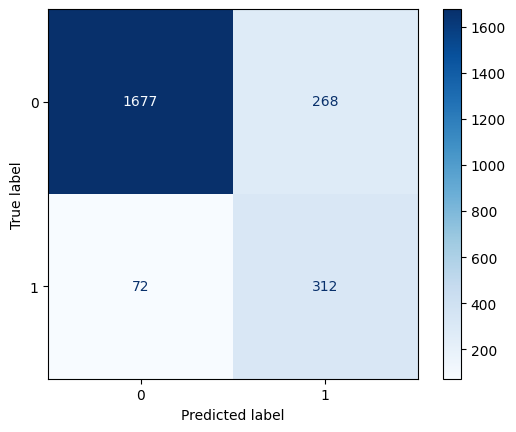

              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91      1945
         1.0       0.54      0.81      0.65       384

    accuracy                           0.85      2329
   macro avg       0.75      0.84      0.78      2329
weighted avg       0.89      0.85      0.86      2329



In [34]:
best_LR = LogisticRegression(C=10, max_iter=100, penalty='l2', tol=0.001, solver='lbfgs')
best_LR.fit(X_train, y_train)
LR_pred = best_LR.predict(X_test)

cm = confusion_matrix(y_test, LR_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(y_test, y_pred=LR_pred))

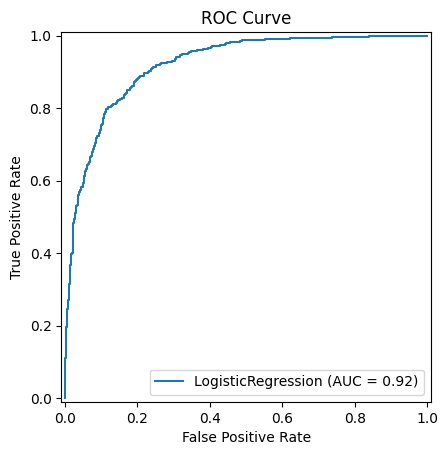

In [35]:
RocCurveDisplay.from_estimator(best_LR, X_test, y_test)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [36]:
y_train_pred = best_LR.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_train_pred)

y_test_pred = best_LR.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_pred)

print(f"Train AUC: {train_auc:.3f}")
print(f"Test AUC: {test_auc:.3f}")

Train AUC: 0.939
Test AUC: 0.920


>Train AUC (0.939) ve Test AUC (0.920) skorları birbirine oldukça yakın olduğu için modelin aşırı öğrenme (overfitting) eğiliminde olmadığı ve genelleme kabiliyetinin yüksek olduğu söylenebilir.


In [37]:
avg_acc_LR = Cross(best_LR, X, y)
avg_acc_LR

89.63

### Destek Vektör Makineleri (SVM)

In [38]:
Models('SVC', X_train, X_test, y_train, y_test)

[[1768  177]
 [  79  305]]
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.93      1945
         1.0       0.63      0.79      0.70       384

    accuracy                           0.89      2329
   macro avg       0.80      0.85      0.82      2329
weighted avg       0.90      0.89      0.89      2329



In [39]:
param_SVC = {
    'C': [0.1, 1, 10],
    'tol': [0.001, 0.0001],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}
   
grid = GridSearchCV(SVC(), param_SVC, refit = True, verbose = 3,n_jobs=-1) 
   
grid.fit(X_train, y_train) 
 
print(grid.best_params_) 

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'tol': 0.001}


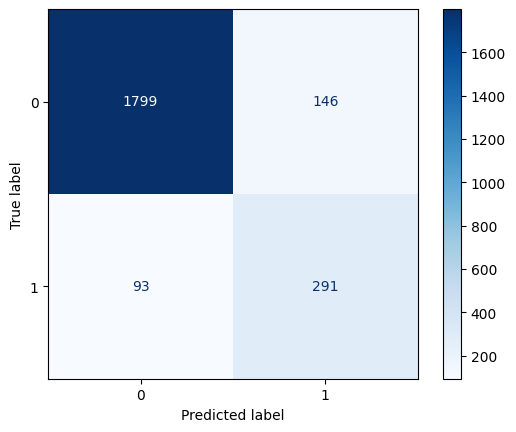

              precision    recall  f1-score   support

         0.0       0.95      0.92      0.94      1945
         1.0       0.67      0.76      0.71       384

    accuracy                           0.90      2329
   macro avg       0.81      0.84      0.82      2329
weighted avg       0.90      0.90      0.90      2329



In [40]:
best_SVC = SVC(C=10, gamma='scale', kernel='rbf', tol=0.001)
best_SVC.fit(X_train, y_train)
SVC_pred = best_SVC.predict(X_test)

cm = confusion_matrix(y_test, SVC_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(y_test, y_pred=SVC_pred))

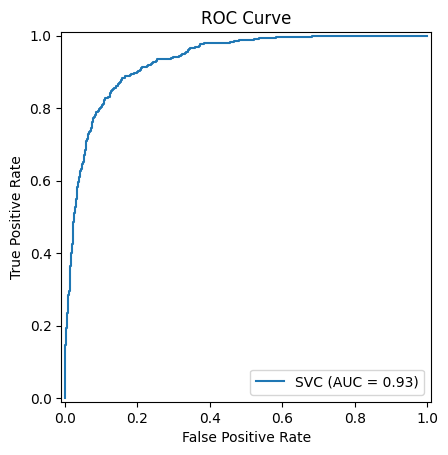

In [41]:
RocCurveDisplay.from_estimator(best_SVC, X_test, y_test)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [42]:
y_train_scores = best_SVC.decision_function(X_train)
train_auc = roc_auc_score(y_train, y_train_scores)

y_test_scores = best_SVC.decision_function(X_test)
test_auc = roc_auc_score(y_test, y_test_scores)

print(f"Train AUC: {train_auc:.3f}")
print(f"Test AUC: {test_auc:.3f}")

Train AUC: 0.990
Test AUC: 0.932


>Train AUC (0.990) ve Test AUC (0.932) skorları da birbirine yakın olduğu için bu modelin de aşırı öğrenme eğiliminde olmadığı ve genelleme kabiliyetinin yüksek olduğu söylenebilir. Ancak bu modelin hafif bir aşırı öğrenme durumu olabilir.

In [43]:
avg_acc_SVC = Cross(best_SVC, X, y)
avg_acc_SVC

90.82

### K-En Yakın Komşu (KNN)

In [44]:
Models('KNN', X_train, X_test, y_train, y_test)

[[1464  481]
 [ 150  234]]
              precision    recall  f1-score   support

         0.0       0.91      0.75      0.82      1945
         1.0       0.33      0.61      0.43       384

    accuracy                           0.73      2329
   macro avg       0.62      0.68      0.62      2329
weighted avg       0.81      0.73      0.76      2329



In [45]:
param_KNN = {'metric':['minkowski', 'euclidian', 'manhattan'],
             'n_neighbors': [3, 5, 7,9 ,11, 13], 
             'weights': ['uniform', 'distance']}
grid = GridSearchCV(KNeighborsClassifier(), param_KNN, refit = True, verbose = 3,n_jobs=-1) 
   
grid.fit(X_train, y_train) 
 
print(grid.best_params_) 

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


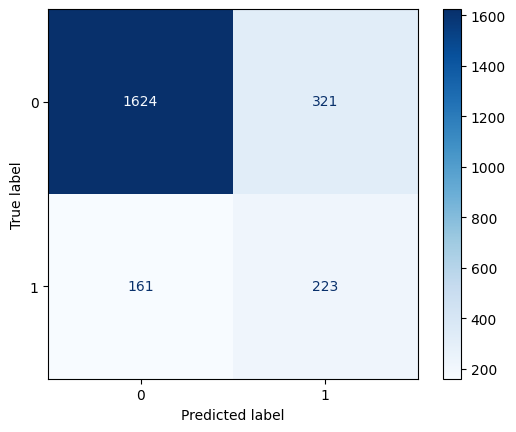

              precision    recall  f1-score   support

         0.0       0.91      0.83      0.87      1945
         1.0       0.41      0.58      0.48       384

    accuracy                           0.79      2329
   macro avg       0.66      0.71      0.68      2329
weighted avg       0.83      0.79      0.81      2329



In [46]:
best_KNN = KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')
best_KNN.fit(X_train, y_train)
KNN_pred = best_KNN.predict(X_test)

cm = confusion_matrix(y_test, KNN_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(y_test, y_pred=KNN_pred))

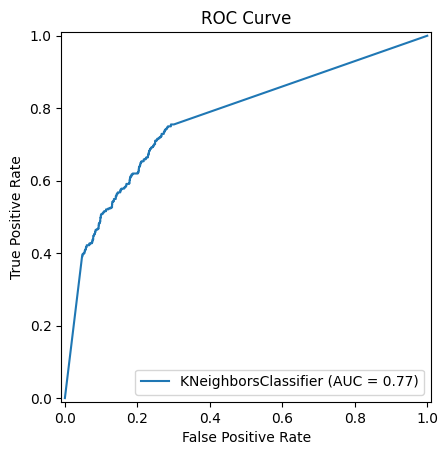

In [47]:
RocCurveDisplay.from_estimator(best_KNN, X_test, y_test)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [48]:
y_train_pred = best_KNN.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_train_pred)

y_test_pred = best_KNN.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_pred)

print(f"Train AUC: {train_auc:.3f}")
print(f"Test AUC: {test_auc:.3f}")

Train AUC: 1.000
Test AUC: 0.773


> Bu modelde ciddi bir aşırı öğrenme durumu söz konusu. Diğer modellere göre başarısız olmuştur.

In [49]:
avg_acc_KNN = Cross(best_KNN, X, y)
avg_acc_KNN

86.12

### Rastgele Orman (Random Forest)

In [50]:
Models('RF', X_train, X_test, y_train, y_test)

[[1892   53]
 [  54  330]]
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1945
         1.0       0.86      0.86      0.86       384

    accuracy                           0.95      2329
   macro avg       0.92      0.92      0.92      2329
weighted avg       0.95      0.95      0.95      2329



In [51]:
param_RF = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 5, 10]
}
grid = GridSearchCV(RandomForestClassifier(), param_RF, refit = True, verbose = 3,n_jobs=-1) 
   
grid.fit(X_train, y_train) 
 
print(grid.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 100}


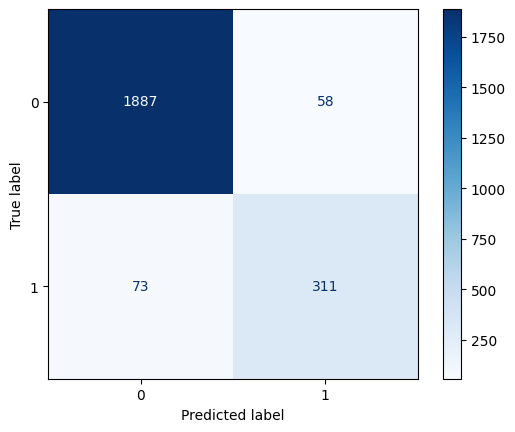

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97      1945
         1.0       0.84      0.81      0.83       384

    accuracy                           0.94      2329
   macro avg       0.90      0.89      0.90      2329
weighted avg       0.94      0.94      0.94      2329



In [52]:
best_RF = RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=1, n_estimators=100)
best_RF.fit(X_train, y_train)
RF_pred = best_RF.predict(X_test)

cm = confusion_matrix(y_test, RF_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(y_test, y_pred=RF_pred))

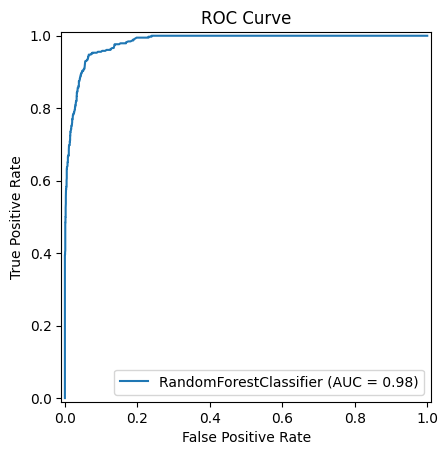

In [53]:
RocCurveDisplay.from_estimator(best_RF, X_test, y_test)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [54]:
y_train_pred = best_RF.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_train_pred)

y_test_pred = best_RF.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_pred)

print(f"Train AUC: {train_auc:.3f}")
print(f"Test AUC: {test_auc:.3f}")

Train AUC: 1.000
Test AUC: 0.983


> Eğitimdeki kusursuzluk hafif aşırı öğrenme riskine işaret edebilir. Ancak genel olarak model, test verisinde yüksek genelleme yeteneği göstermiştir.

In [55]:
avg_acc_RF = Cross(best_RF, X, y)
avg_acc_RF

94.95

## Aykırı Değerlerin Hariç Tutulmadığı Durum

### Lojistik Regresyon

In [56]:
Models('LR', X_train2, X_test2, y_train2, y_test2)

[[1824  301]
 [  66  341]]
              precision    recall  f1-score   support

         0.0       0.97      0.86      0.91      2125
         1.0       0.53      0.84      0.65       407

    accuracy                           0.86      2532
   macro avg       0.75      0.85      0.78      2532
weighted avg       0.90      0.86      0.87      2532



In [57]:
param_LR2 = {
    'penalty': ['l2'],  # liblinear destekliyorsa 'l1' da eklenebilir
    'C': [0.01, 0.1, 1, 10, 100],  # regularizasyon gücü (1/C)
    'solver': ['lbfgs', 'liblinear'],  # lbfgs çok yönlüdür
    'max_iter': [100, 200, 500],
    'tol': [1e-3, 1e-4, 1e-5]
}  
grid = GridSearchCV(LogisticRegression(), param_LR2, refit = True, verbose = 3,n_jobs=-1) 
   
grid.fit(X_train2, y_train2)  
print(grid.best_params_) 

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.001}


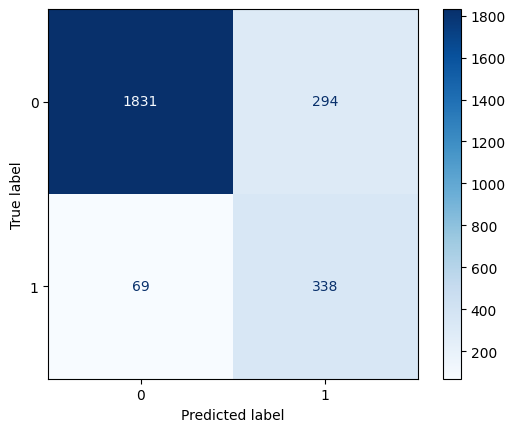

              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91      2125
         1.0       0.53      0.83      0.65       407

    accuracy                           0.86      2532
   macro avg       0.75      0.85      0.78      2532
weighted avg       0.89      0.86      0.87      2532



In [58]:
best_LR2 = LogisticRegression(C=100, max_iter=100, penalty='l2', tol=0.001, solver='lbfgs')
best_LR2.fit(X_train2, y_train2)
LR2_pred = best_LR2.predict(X_test2)

cm = confusion_matrix(y_test2, LR2_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(y_test2, y_pred=LR2_pred))

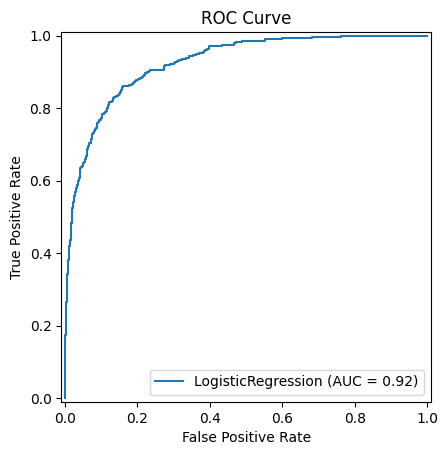

In [59]:
RocCurveDisplay.from_estimator(best_LR2, X_test2, y_test2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [60]:
y_train_pred = best_LR2.predict_proba(X_train2)[:, 1]
train_auc = roc_auc_score(y_train2, y_train_pred)

y_test_pred = best_LR2.predict_proba(X_test2)[:, 1]
test_auc = roc_auc_score(y_test2, y_test_pred)

print(f"Train AUC: {train_auc:.3f}")
print(f"Test AUC: {test_auc:.3f}")

Train AUC: 0.933
Test AUC: 0.925


> Aykırı değerlerin hariç tutulduğu versiyonda olduğu gibi skorlar birbirine yakın olduğu için modelin aşırı öğrenme eğiliminde olmadığı ve genelleme kabiliyetinin yüksek olduğu söylenebilir.

In [61]:
avg_acc_LR2 = Cross(best_LR2, X2, y2)
avg_acc_LR2

90.06

### Destek Vektör Makineleri (SVM)

In [62]:
Models('SVC', X_train2, X_test2, y_train2, y_test2)

[[1904  221]
 [  80  327]]
              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93      2125
         1.0       0.60      0.80      0.68       407

    accuracy                           0.88      2532
   macro avg       0.78      0.85      0.81      2532
weighted avg       0.90      0.88      0.89      2532



In [63]:
param_SVC2 = {
    'C': [0.1, 1, 10],
    'tol': [0.001, 0.0001],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}
   
grid = GridSearchCV(SVC(), param_SVC2, refit = True, verbose = 3,n_jobs=-1) 
   
grid.fit(X_train2, y_train2) 
 
print(grid.best_params_) 

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'tol': 0.001}


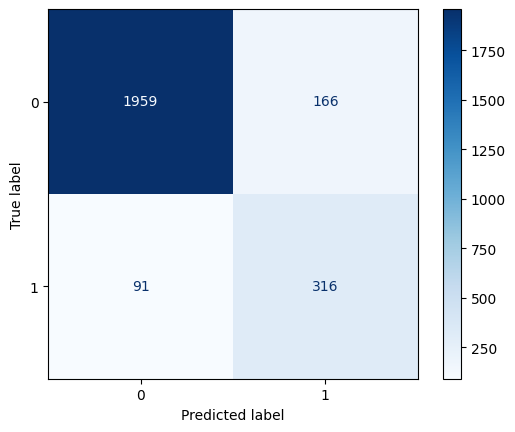

              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94      2125
         1.0       0.66      0.78      0.71       407

    accuracy                           0.90      2532
   macro avg       0.81      0.85      0.82      2532
weighted avg       0.91      0.90      0.90      2532



In [64]:
best_SVC2 = SVC(C=10, gamma='scale', kernel='rbf', tol=0.001)
best_SVC2.fit(X_train2, y_train2)
SVC2_pred = best_SVC2.predict(X_test2)

cm = confusion_matrix(y_test2, SVC2_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(y_test2, y_pred=SVC2_pred))

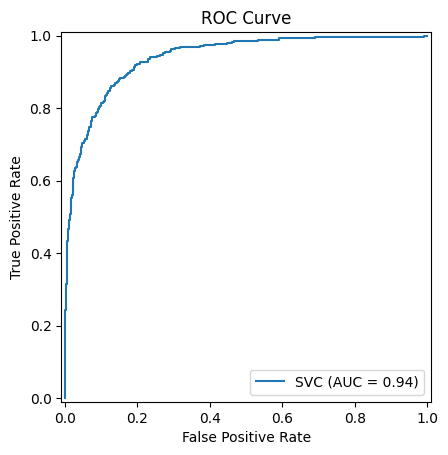

In [65]:
RocCurveDisplay.from_estimator(best_SVC2, X_test2, y_test2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [66]:
y_train_scores = best_SVC2.decision_function(X_train2)
train_auc = roc_auc_score(y_train2, y_train_scores)

y_test_scores = best_SVC2.decision_function(X_test2)
test_auc = roc_auc_score(y_test2, y_test_scores)

print(f"Train AUC: {train_auc:.3f}")
print(f"Test AUC: {test_auc:.3f}")

Train AUC: 0.987
Test AUC: 0.940


> SVM'de aykırı değerlerin hariç tutulmadığı versiyonda skorlar birbirine biraz daha yakın olduğu için bu versiyona aşırı öğrenme konusunda daha güvenli ve genelleme kabiliyetinin daha yüksek olduğu söylenebilir.

In [67]:
avg_acc_SVC2 = Cross(best_SVC2, X2, y2)
avg_acc_SVC2

91.36

### K-En Yakın Komşu (KNN)

In [68]:
Models('KNN', X_train2, X_test2, y_train2, y_test2)

[[1557  568]
 [ 139  268]]
              precision    recall  f1-score   support

         0.0       0.92      0.73      0.81      2125
         1.0       0.32      0.66      0.43       407

    accuracy                           0.72      2532
   macro avg       0.62      0.70      0.62      2532
weighted avg       0.82      0.72      0.75      2532



In [69]:
param_KNN2 = {'metric':['minkowski', 'euclidian', 'manhattan'],
             'n_neighbors': [3, 5, 7,9 ,11, 13], 
             'weights': ['uniform', 'distance']}
grid = GridSearchCV(KNeighborsClassifier(), param_KNN2, refit = True, verbose = 3,n_jobs=-1) 
   
grid.fit(X_train2, y_train2) 
 
print(grid.best_params_) 

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


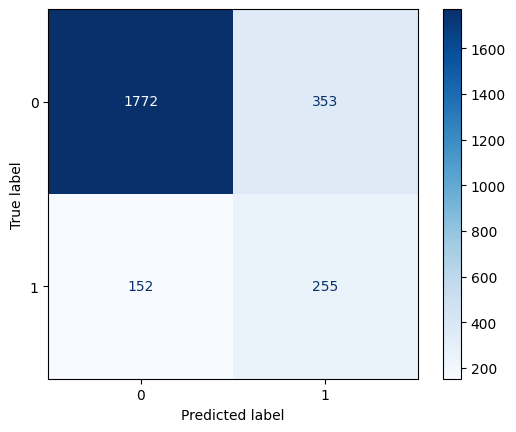

              precision    recall  f1-score   support

         0.0       0.92      0.83      0.88      2125
         1.0       0.42      0.63      0.50       407

    accuracy                           0.80      2532
   macro avg       0.67      0.73      0.69      2532
weighted avg       0.84      0.80      0.82      2532



In [70]:
best_KNN2 = KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')
best_KNN2.fit(X_train2, y_train2)
KNN2_pred = best_KNN2.predict(X_test2)

cm = confusion_matrix(y_test2, KNN2_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(y_test2, y_pred=KNN2_pred))

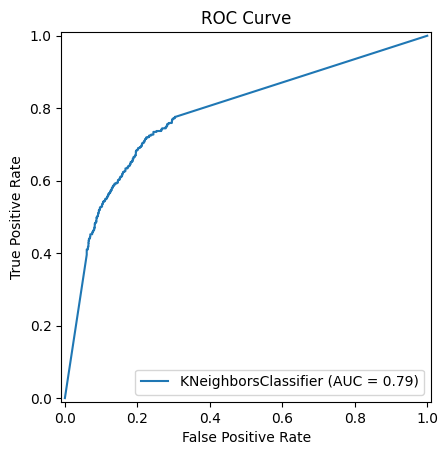

In [71]:
RocCurveDisplay.from_estimator(best_KNN2, X_test2, y_test2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [72]:
y_train_pred = best_KNN2.predict_proba(X_train2)[:, 1]
train_auc = roc_auc_score(y_train2, y_train_pred)

y_test_pred = best_KNN2.predict_proba(X_test2)[:, 1]
test_auc = roc_auc_score(y_test2, y_test_pred)

print(f"Train AUC: {train_auc:.3f}")
print(f"Test AUC: {test_auc:.3f}")

Train AUC: 1.000
Test AUC: 0.785


> Bu modelde yine ciddi bir aşırı öğrenme durumu söz konusu.

In [73]:
avg_acc_KNN2 = Cross(best_KNN2, X2, y2)
avg_acc_KNN2

86.4

### Rastgele Orman (Random Forest)

In [74]:
Models('RF', X_train2, X_test2, y_train2, y_test2)

[[2077   48]
 [  69  338]]
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      2125
         1.0       0.88      0.83      0.85       407

    accuracy                           0.95      2532
   macro avg       0.92      0.90      0.91      2532
weighted avg       0.95      0.95      0.95      2532



In [75]:
param_RF2 = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 5, 10]
}
grid = GridSearchCV(RandomForestClassifier(), param_RF2, refit = True, verbose = 3,n_jobs=-1) 
   
grid.fit(X_train2, y_train2) 
 
print(grid.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 100}


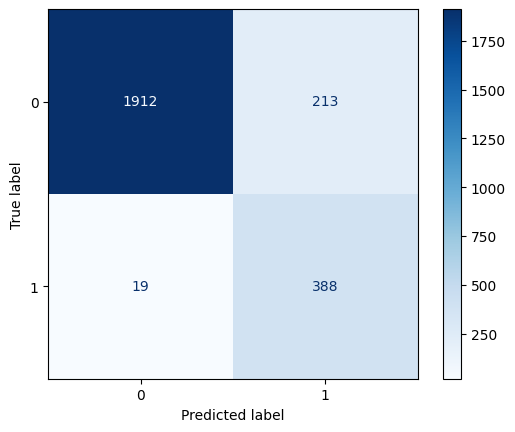

              precision    recall  f1-score   support

         0.0       0.99      0.90      0.94      2125
         1.0       0.65      0.95      0.77       407

    accuracy                           0.91      2532
   macro avg       0.82      0.93      0.86      2532
weighted avg       0.93      0.91      0.91      2532



In [76]:
best_RF2 = RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_leaf=1, n_estimators=100)
best_RF2.fit(X_train2, y_train2)
RF2_pred = best_RF.predict(X_test2)

cm = confusion_matrix(y_test2, RF2_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(y_test2, y_pred=RF2_pred))

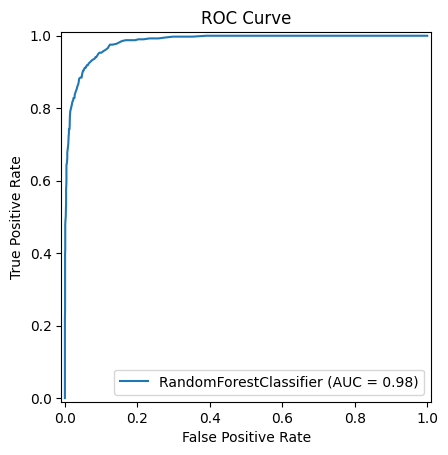

In [77]:
RocCurveDisplay.from_estimator(best_RF2, X_test2, y_test2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [78]:
y_train_pred = best_RF2.predict_proba(X_train2)[:, 1]
train_auc = roc_auc_score(y_train2, y_train_pred)

y_test_pred = best_RF2.predict_proba(X_test2)[:, 1]
test_auc = roc_auc_score(y_test2, y_test_pred)

print(f"Train AUC: {train_auc:.3f}")
print(f"Test AUC: {test_auc:.3f}")

Train AUC: 1.000
Test AUC: 0.983


> Yİne eğitimdeki kusursuzluk hafif aşırı öğrenme riskine işaret edebilir. Ancak bu versiyonda model, test verisinde daha da yüksek genelleme yeteneği göstermiştir.

In [79]:
avg_acc_RF2 = Cross(best_RF2, X2, y2)
avg_acc_RF2

94.97

# 4. Sonuçların Değerlendirilmesi

> Aşağıda dörder makine öğrenmesi yönteminden 2 versiyonun toplam 8 modelininin çapraz doğrulama ile elde edilmiş başarı oranları listelenmektedir.

In [80]:
accuracies = [{"LR (with dropping outliers)": avg_acc_LR,
              "SVM (with dropping outliers)": avg_acc_SVC,
              "KNN (with dropping outliers)": avg_acc_KNN,
              "RF (with dropping outliers)": avg_acc_RF,
              "LR (without dropping outliers)": avg_acc_LR2,
              "SVM (without dropping outliers)": avg_acc_SVC2,
              "KNN (without dropping outliers)": avg_acc_KNN2,
              "RF (without dropping outliers)": avg_acc_RF2}]
acc_df = pd.DataFrame.from_dict(accuracies)
acc_df = acc_df.T
acc_df.rename(columns={0:'Accuracies of Models'},inplace=True)
sorted_acc = pd.DataFrame(acc_df.sort_values(by = 'Accuracies of Models'))
sorted_acc

,Accuracies of Models
KNN (with dropping outliers),86.12
KNN (without dropping outliers),86.40
LR (with dropping outliers),89.63
LR (without dropping outliers),90.06
SVM (with dropping outliers),90.82
SVM (without dropping outliers),91.36
RF (with dropping outliers),94.95
RF (without dropping outliers),94.97


>En başarılı model iki versiyonda da Rastgele Orman (Random Forest) olmuştur. Aşağıda ise en başarılı modelin öğrenmesine etki eden değişkenlerin önem katsayısı sıralanmıştır.

In [81]:
importances = best_RF2.feature_importances_
features = X2.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=True) 
importance_df

,Feature,Importance
14,Avg_Utilization_Ratio,0.000000
25,Card_Category_Gold,0.000730
26,Card_Category_Silver,0.001475
19,Education_Level_Post-Graduate,0.001815
21,Marital_Status_Divorced,0.001913
27,Income_Category_$120K +,0.002144
24,Card_Category_Blue,0.002219
16,Education_Level_Doctorate,0.002312
15,Education_Level_College,0.002833
28,Income_Category_$40K - $60K,0.003143


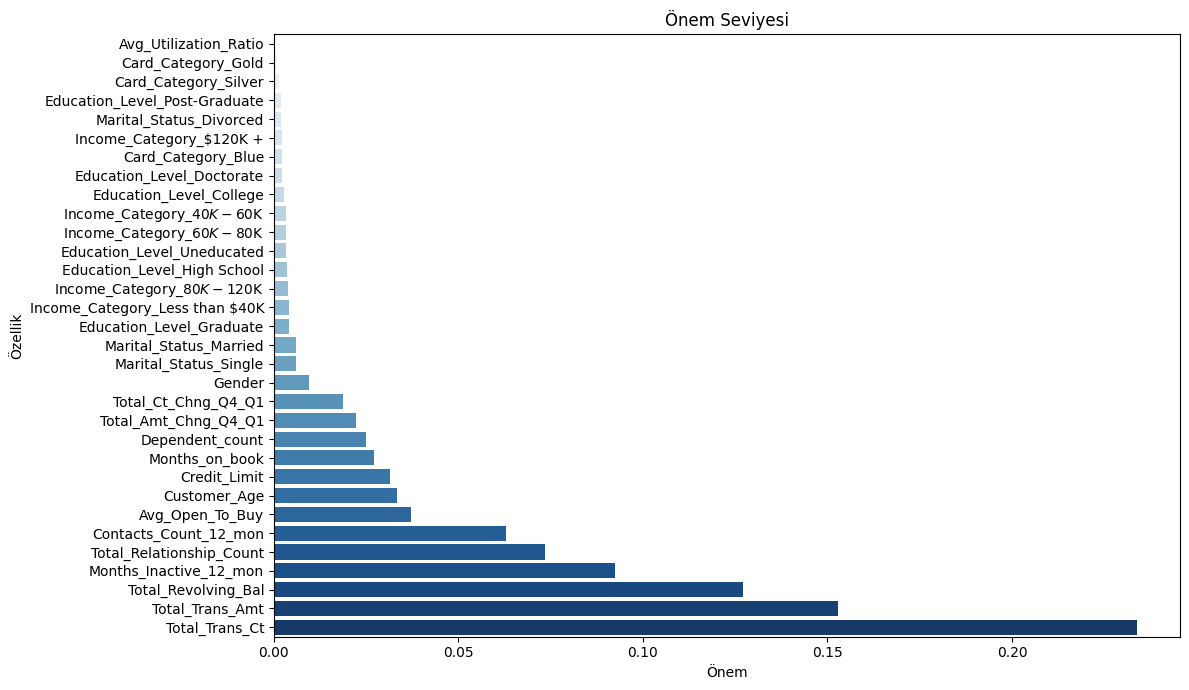

In [82]:
plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues') 
plt.title('Önem Seviyesi')
plt.xlabel('Önem')
plt.ylabel('Özellik')
plt.tight_layout()
plt.show()

> Modelin öğrenmesine en çok etki eden alanların:
> -Total_Trans_Ct – Toplam işlem sayısı (12 aylık)
> -Total_Trans_Amt – Toplam işlem tutarı (12 aylık)
> -Total_Revolving_Bal – Toplam dönen bakiye (borç)
> -Months_Inactive_12_mon – Son 12 ayda kaç ay pasif kaldığı
> -Contacts_Count_12_mon – Son 12 ayda bankayla kaç kez iletişime geçtiği
> -Total_Relationship_Count – Bankayla olan toplam ilişki sayısı (ürün sayısı) olduğu görülmüştür.